In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Training and forecast example of an automated ARIMA model (TBATS).

from rdn_train_test_split import rdn_train_test_split
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta
from tbats import TBATS
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import math
from evaluate_forecasts import simple_n_day_ahead_forecast
import os

# ## Load dataset


ts60 = pd.read_csv(
    '../../RDN/Load Data (2018-2019)/artifacts/load_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Load'].dropna()
load60.head()

steps = 24
days_ahead = 7
last_train_year_id = 2019
last_train_month_id = 12
last_train_day_id = 3
last_train_day = datetime(last_train_year_id, last_train_month_id,
                          last_train_day_id)  # a week finishes there
model_id_date = f'{last_train_year_id}_{last_train_month_id}_{last_train_day_id}'

#scaler
scaler_class = StandardScaler()

# model storing directory
# model_dir = '../../RDN/Load Data(2018-2019)/models/'
model_dir = '.'


# ## Train / test split


train, test = rdn_train_test_split(load60,
                                   last_train_day,
                                   days_ahead,
                                   steps,
                                   freq='H')

scaler = scaler_class.fit(train.values.reshape(-1, 1))
train_scaled = pd.Series(scaler.transform(train.values.reshape(-1, 1)).reshape(-1), index=train.index)
test_scaled = pd.Series(scaler.transform(test.values.reshape(-1, 1)).reshape(-1), index=test.index)

[2021-09-15 16:25:39,066] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[prophet] or u8darts[all].


In [2]:
%%time                                             
# # ## Training TBATS
# # In this section the TBATS model is fitted.

# # ### Fit TBATS

# # Fit the model
print("Training TBATS...\n")
estimator = TBATS(seasonal_periods=(24, 168, 365), use_box_cox=True, n_jobs=8,
                  use_arma_errors=True, use_damped_trend=True, use_trend=True)
tbats = estimator.fit(train_scaled)
tbats.summary()

Training TBATS...



c:\Ubuntu\Dev\Windows\I-NERGY\venv\lib\site-packages\tbats\error\ExceptionHandler.py:13: InputArgsWarning: Box-Cox transformation (use_box_cox) was forced to True but there are negative values in input series. Setting use_box_cox to False.
  warnings.warn(message, warning_type)


Simple 7 day ahead forecast:



<Figure size 432x288 with 0 Axes>

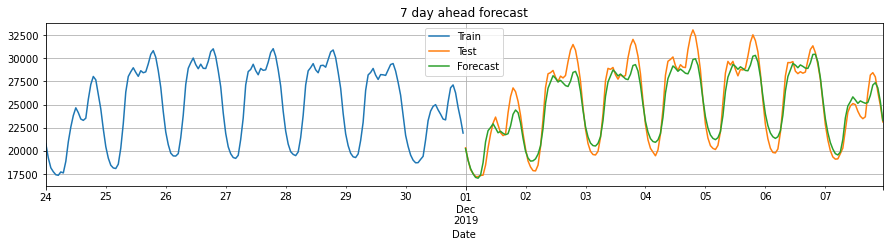

{'MAPE naive': 0.044963771996523905,
 'MAPE': 0.03941504171145729,
 'MSE': 1658728.499577374,
 'RMSE': 1287.9163402866561}

In [ ]:
### Forecast
predictions, metrics = simple_n_day_ahead_forecast(tbats, days_ahead, steps, train, test, scaler)
metrics

In [ ]:
# Save scaler for next stages
with open(os.path.join(model_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
### Save model locally
fname = os.path.join(model_dir, f"rdn_tbats_{model_id_date}.pkl")
with open(fname, 'wb') as file:
    pickle.dump(tbats, file)